<a href="https://colab.research.google.com/github/stevengregori92/CNN-Intro/blob/main/Lung_Classification_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "jcopdl<2.0"

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17913 sha256=325fe113c1d3da5c9eb8d528e360d2983d266ba53a8b35052019d016de3f988d
  Stored in directory: /root/.cache/pip/wheels/41/95/30/86345d2446be19c7d97dee789a2597bee81cfbb7b24a847f7c
Successfully built jcopdl


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
!gdown https://drive.google.com/uc?id=1uwwFXTnfsHcqig2YL1g_DDmiRGe1Ymwz

Downloading...
From: https://drive.google.com/uc?id=1uwwFXTnfsHcqig2YL1g_DDmiRGe1Ymwz
To: /content/covid.zip
100% 166M/166M [00:02<00:00, 62.1MB/s]


In [ ]:
!unzip /content/covid.zip

Archive:  /content/covid.zip
  inflating: Covid19-dataset/test/Covid/0100.jpeg  
  inflating: Covid19-dataset/test/Covid/0102.jpeg  
  inflating: Covid19-dataset/test/Covid/0105.png  
  inflating: Covid19-dataset/test/Covid/0106.jpeg  
  inflating: Covid19-dataset/test/Covid/0108.jpeg  
  inflating: Covid19-dataset/test/Covid/0111.jpg  
  inflating: Covid19-dataset/test/Covid/0112.jpg  
  inflating: Covid19-dataset/test/Covid/0113.jpg  
  inflating: Covid19-dataset/test/Covid/0115.jpeg  
  inflating: Covid19-dataset/test/Covid/0118.jpeg  
  inflating: Covid19-dataset/test/Covid/0119.jpeg  
  inflating: Covid19-dataset/test/Covid/0120.jpg  
  inflating: Covid19-dataset/test/Covid/094.png  
  inflating: Covid19-dataset/test/Covid/096.png  
  inflating: Covid19-dataset/test/Covid/098.jpeg  
  inflating: Covid19-dataset/test/Covid/COVID-00003b.jpg  
  inflating: Covid19-dataset/test/Covid/COVID-00012.jpg  
  inflating: Covid19-dataset/test/Covid/COVID-00022.jpg  
  inflating: Covid19-datas

#Dataset & Dataloader

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('Covid19-dataset/train/', transform=train_transform)
trainloader = DataLoader(train_set, batch_size = bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder('Covid19-dataset/test/', transform=test_transform)
testloader = DataLoader(test_set, batch_size = bs, shuffle=True)

In [ ]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

#Arsitektur & Config

In [ ]:
from jcopdl.layers import conv_block, linear_block

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv=nn.Sequential(
        conv_block(3, 8),
        conv_block(8, 16),
        conv_block(16, 32),
        conv_block(32, 64),
        nn.Flatten()
    )
    self.fc = nn.Sequential(
        linear_block(1024, 256, dropout=0.1),
        linear_block(256, 3, activation='lsoftmax')
    )

  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)
    return x

In [ ]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size
})

#Training Preparation

In [ ]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
callback = Callback(model, config, outdir='model/cnn')

#Training

In [ ]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  cost = correct = 0

  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    cost += loss.item()*feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()

  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 1.1106 | Test_cost  = 1.1043 | Train_score = 0.2789 | Test_score = 0.3030 |


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 1.1069 | Test_cost  = 1.1025 | Train_score = 0.2789 | Test_score = 0.3030 |
==> EarlyStop patience =  1 | Best test_score: 0.3030


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 1.1033 | Test_cost  = 1.1009 | Train_score = 0.2789 | Test_score = 0.3030 |
==> EarlyStop patience =  2 | Best test_score: 0.3030


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 1.1007 | Test_cost  = 1.0994 | Train_score = 0.2789 | Test_score = 0.3030 |
==> EarlyStop patience =  3 | Best test_score: 0.3030


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 1.0983 | Test_cost  = 1.0982 | Train_score = 0.3028 | Test_score = 0.3333 |


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 1.0959 | Test_cost  = 1.0970 | Train_score = 0.4143 | Test_score = 0.3939 |


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bd360564700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bd360564700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 1.0931 | Test_cost  = 1.0960 | Train_score = 0.4343 | Test_score = 0.3939 |
==> EarlyStop patience =  1 | Best test_score: 0.3939


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 1.0903 | Test_cost  = 1.0951 | Train_score = 0.4422 | Test_score = 0.3939 |
==> EarlyStop patience =  2 | Best test_score: 0.3939


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 1.0877 | Test_cost  = 1.0944 | Train_score = 0.4422 | Test_score = 0.3939 |
==> EarlyStop patience =  3 | Best test_score: 0.3939


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 1.0863 | Test_cost  = 1.0938 | Train_score = 0.4422 | Test_score = 0.3939 |
==> EarlyStop patience =  4 | Best test_score: 0.3939


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 1.0833 | Test_cost  = 1.0934 | Train_score = 0.4422 | Test_score = 0.3939 |
==> EarlyStop patience =  5 | Best test_score: 0.3939
==> Execute Early Stopping at epoch: 11 | Best test_score: 0.3939
==> Best model is saved at model/cnn


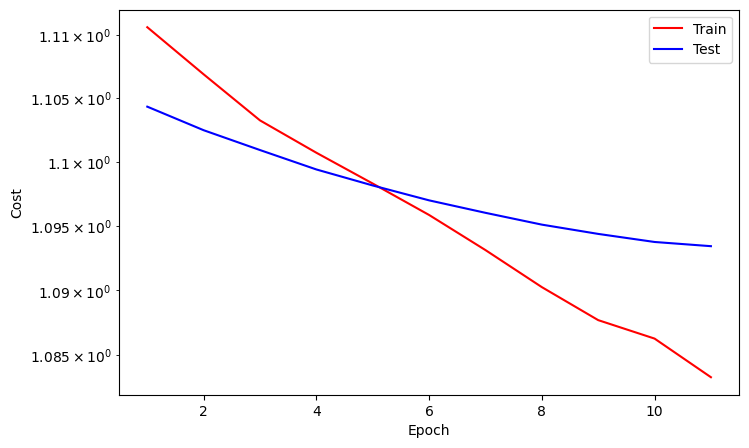

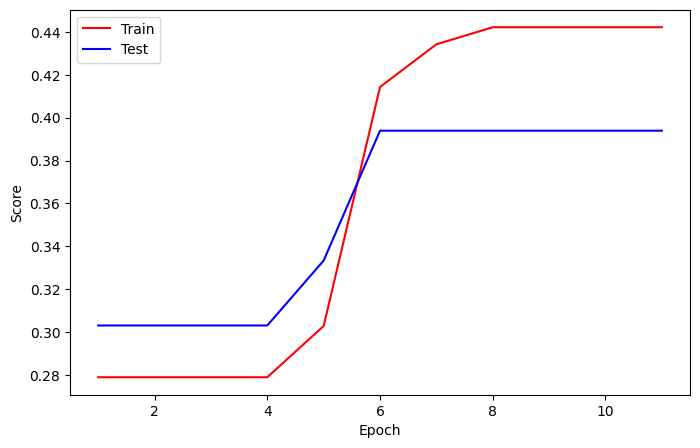

In [ ]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

   #Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  #Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break